In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

# 1-D Example Data

## Create Model

In [2]:
phys_space = np.random.randn(500,1)
feat_space = np.random.randn(500,3)

# np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)
dist2 = scipy.stats.bernoulli(0.45)

In [3]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        if  dist2.rvs():
            val = 2 - val
        else:
            val = 1 - val
    latent_1D[i] = val

In [4]:
latent_1D = np.ones(25)*2
latent_1D = np.append(latent_1D, np.ones(75)*0)
latent_1D = np.append(latent_1D, np.ones(100)*1)
latent_1D = np.append(latent_1D, np.ones(50)*2)
latent_1D = np.append(latent_1D, np.ones(25)*1)
latent_1D = np.append(latent_1D, np.ones(25)*2)
latent_1D = np.append(latent_1D, np.ones(100)*0)
latent_1D = np.append(latent_1D, np.ones(100)*2)

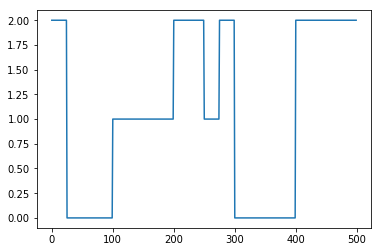

In [5]:
plt.plot(latent_1D);

In [6]:
i = 4
c1 = scipy.stats.multivariate_normal([7,9,10,3], np.eye(i)*0.35)
c2 = scipy.stats.multivariate_normal([8,8,10,2], np.eye(i)*0.55)
c3 = scipy.stats.multivariate_normal([8,10,9,1], np.eye(i)*0.25)
#c4 = scipy.stats.multivariate_normal([8,10,9,4], np.eye(i)*0.25)

## Sample Data

In [7]:
obs = np.empty((len(phys_space[:,0]), 4))
np.shape(obs)

(500, 4)

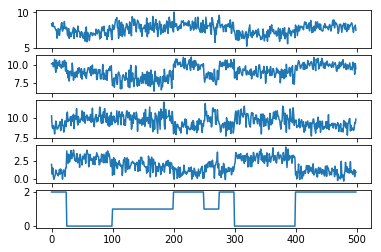

In [8]:
obs = np.empty((len(phys_space[:,0]), 4))

for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
    elif l == 2:
        obs[i,:] = c3.rvs()
        
fig, ax = plt.subplots(5,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(obs[:,2])
ax[3].plot(obs[:,3])
ax[4].plot(latent_1D)

C:\Users\Alexander\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


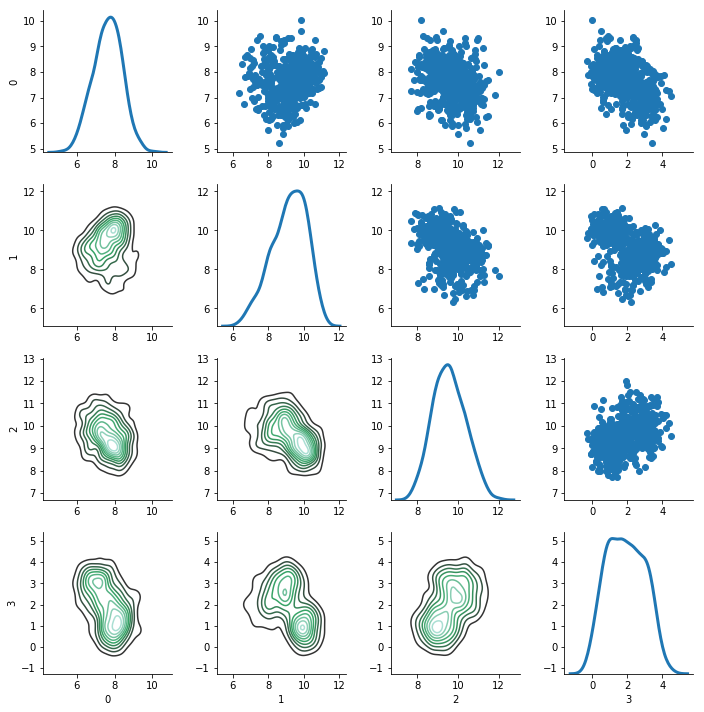

In [17]:
import seaborn as sns
df = pd.DataFrame(obs)

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

## Try

In [9]:
ex1 = hmrf_gmm.HMRFGMM(phys_space, obs, n_labels=3, beta_init=10)

In [10]:
np.shape(obs)

(500, 4)

In [11]:
np.shape(phys_space)

(500, 1)

In [15]:
ex1.fit(250, beta_jump_length=10, verbose=True)

  0%|                                                                                       | 0/250 [00:00<?, ?it/s]

MU acceptance ratio: 0.770793350454
MU acceptance ratio: 0.663920842074
MU acceptance ratio: 0.742105263251
COV acceptance ratio: 0.86616383183
COV acceptance ratio: 0.736496333834
COV acceptance ratio: 0.983258831311
BETA acceptance ratio: [[ 1.00157711]]


  0%|▎                                                                              | 1/250 [00:05<22:46,  5.49s/it]

MU acceptance ratio: 0.584779247192
MU acceptance ratio: 0.743779386658
MU acceptance ratio: 0.398737218268
COV acceptance ratio: 0.954507772603
COV acceptance ratio: 1.07912602343
COV acceptance ratio: 1.48965875634
BETA acceptance ratio: [[ 1.00358257]]


  1%|▋                                                                              | 2/250 [00:10<22:43,  5.50s/it]

MU acceptance ratio: 0.59849229916
MU acceptance ratio: 0.641401217866
MU acceptance ratio: 0.767535675822
COV acceptance ratio: 1.08164981402
COV acceptance ratio: 1.09833740815
COV acceptance ratio: 1.36279630858
BETA acceptance ratio: [[ 1.00385933]]


  1%|▉                                                                              | 3/250 [00:16<22:39,  5.51s/it]

MU acceptance ratio: 0.232051040947
MU acceptance ratio: 0.746237345717
MU acceptance ratio: 0.537584240969
COV acceptance ratio: 1.06242583444
COV acceptance ratio: 1.02823641106
COV acceptance ratio: 0.722980671806
BETA acceptance ratio: [[ 1.00333205]]


  2%|█▎                                                                             | 4/250 [00:21<22:32,  5.50s/it]

MU acceptance ratio: 0.36487827567
MU acceptance ratio: 0.752498964268
MU acceptance ratio: 0.0778543405907
COV acceptance ratio: 0.900715823332
COV acceptance ratio: 1.14069847871
COV acceptance ratio: 1.91051224321
BETA acceptance ratio: [[ 1.00198304]]


  2%|█▌                                                                             | 5/250 [00:27<22:25,  5.49s/it]

MU acceptance ratio: 0.404592536037
MU acceptance ratio: 0.368561657673
MU acceptance ratio: 0.308527364379
COV acceptance ratio: 0.926213793314
COV acceptance ratio: 0.811485582388
COV acceptance ratio: 1.42538831012
BETA acceptance ratio: [[ 0.99866289]]


  2%|█▉                                                                             | 6/250 [00:32<22:19,  5.49s/it]

MU acceptance ratio: 2.31338432374
MU acceptance ratio: 0.714517768081
MU acceptance ratio: 4.34407466288
COV acceptance ratio: 0.910812008043
COV acceptance ratio: 0.928023323155
COV acceptance ratio: 1.14848722516
BETA acceptance ratio: [[ 0.99931499]]


  3%|██▏                                                                            | 7/250 [00:38<22:13,  5.49s/it]

MU acceptance ratio: 1.41650996872
MU acceptance ratio: 0.710556828276
MU acceptance ratio: 1.65152176343
COV acceptance ratio: 1.02842342269
COV acceptance ratio: 1.19636301198
COV acceptance ratio: 0.673598709187
BETA acceptance ratio: [[ 0.99569971]]


  3%|██▌                                                                            | 8/250 [00:43<22:07,  5.48s/it]

MU acceptance ratio: 1.92316577897
MU acceptance ratio: 0.351059260084
MU acceptance ratio: 1.44447411005
COV acceptance ratio: 1.09094015318
COV acceptance ratio: 0.707763879509
COV acceptance ratio: 0.854668797406
BETA acceptance ratio: [[ 0.99855439]]


  4%|██▊                                                                            | 9/250 [00:49<22:02,  5.49s/it]

MU acceptance ratio: 0.562653669326
MU acceptance ratio: 0.618374528237
MU acceptance ratio: 0.860169312892
COV acceptance ratio: 0.881242535094
COV acceptance ratio: 1.03450112776
COV acceptance ratio: 1.15837131078
BETA acceptance ratio: [[ 1.00340709]]


  4%|███                                                                           | 10/250 [00:54<21:56,  5.49s/it]

MU acceptance ratio: 0.243189343835
MU acceptance ratio: 0.75436979511
MU acceptance ratio: 0.549668404319
COV acceptance ratio: 1.05505158218
COV acceptance ratio: 0.85266930195
COV acceptance ratio: 0.964239118841
BETA acceptance ratio: [[ 0.99571289]]


  4%|███▍                                                                          | 11/250 [01:00<21:51,  5.49s/it]

MU acceptance ratio: 0.198906513363
MU acceptance ratio: 0.0713953953979
MU acceptance ratio: 0.549863694032
COV acceptance ratio: 0.882760910292
COV acceptance ratio: 1.07015306946
COV acceptance ratio: 0.719811787504
BETA acceptance ratio: [[ 1.00104938]]


  5%|███▋                                                                          | 12/250 [01:05<21:44,  5.48s/it]

MU acceptance ratio: 0.144046521281
MU acceptance ratio: 1.34781969783
MU acceptance ratio: 0.800305764907
COV acceptance ratio: 0.990325003316
COV acceptance ratio: 0.845680940482
COV acceptance ratio: 1.3618246487
BETA acceptance ratio: [[ 0.99553828]]


  5%|████                                                                          | 13/250 [01:11<21:39,  5.48s/it]

MU acceptance ratio: 0.0487126870819
MU acceptance ratio: 0.525043075121
MU acceptance ratio: 0.450640695758
COV acceptance ratio: 0.94586393084
COV acceptance ratio: 0.835332974371
COV acceptance ratio: 0.786561419623
BETA acceptance ratio: [[ 0.99951619]]


  6%|████▎                                                                         | 14/250 [01:16<21:33,  5.48s/it]

MU acceptance ratio: 0.0206416808395
MU acceptance ratio: 0.152347011646
MU acceptance ratio: 0.532816659478
COV acceptance ratio: 0.944018371187
COV acceptance ratio: 1.12807033225
COV acceptance ratio: 0.93973812677
BETA acceptance ratio: [[ 0.99853155]]


  6%|████▋                                                                         | 15/250 [01:22<21:27,  5.48s/it]

MU acceptance ratio: 3.7517350632
MU acceptance ratio: 4.11257686113
MU acceptance ratio: 1.85650908245
COV acceptance ratio: 1.08034913976
COV acceptance ratio: 0.844285370793
COV acceptance ratio: 1.0650212088
BETA acceptance ratio: [[ 0.9996592]]


  6%|████▉                                                                         | 16/250 [01:27<21:22,  5.48s/it]

MU acceptance ratio: 1.74380535433
MU acceptance ratio: 0.0615982985388
MU acceptance ratio: 0.432037300833
COV acceptance ratio: 1.03391792723
COV acceptance ratio: 1.11812460432
COV acceptance ratio: 1.12415827915
BETA acceptance ratio: [[ 1.00382584]]


  7%|█████▎                                                                        | 17/250 [01:33<21:17,  5.48s/it]

MU acceptance ratio: 0.926526112205
MU acceptance ratio: 0.161056903922
MU acceptance ratio: 0.947494527882
COV acceptance ratio: 0.915622170079
COV acceptance ratio: 1.02500507151
COV acceptance ratio: 1.087284722
BETA acceptance ratio: [[ 1.00575436]]


  7%|█████▌                                                                        | 18/250 [01:38<21:11,  5.48s/it]

MU acceptance ratio: 0.723780517716
MU acceptance ratio: 0.373494284047
MU acceptance ratio: 0.115154854144
COV acceptance ratio: 0.805082413339
COV acceptance ratio: 0.888003885207
COV acceptance ratio: 1.22155162963
BETA acceptance ratio: [[ 0.99502502]]


  8%|█████▉                                                                        | 19/250 [01:44<21:05,  5.48s/it]

MU acceptance ratio: 0.172260723164
MU acceptance ratio: 0.242076514332
MU acceptance ratio: 0.911796850006
COV acceptance ratio: 1.00236050623
COV acceptance ratio: 1.19109453326
COV acceptance ratio: 0.939110937859
BETA acceptance ratio: [[ 0.99484965]]


  8%|██████▏                                                                       | 20/250 [01:49<21:00,  5.48s/it]

MU acceptance ratio: 0.46700800827
MU acceptance ratio: 0.617995776105
MU acceptance ratio: 5.25297208925
COV acceptance ratio: 1.02944830465
COV acceptance ratio: 0.982127645677
COV acceptance ratio: 0.763673489362
BETA acceptance ratio: [[ 0.9964996]]


  8%|██████▌                                                                       | 21/250 [01:55<20:54,  5.48s/it]

MU acceptance ratio: 0.771285483489
MU acceptance ratio: 12.8841743197
MU acceptance ratio: 0.153632262618
COV acceptance ratio: 1.0041514734
COV acceptance ratio: 1.05532704399
COV acceptance ratio: 1.22661837119
BETA acceptance ratio: [[ 0.99444215]]


  9%|██████▊                                                                       | 22/250 [02:00<20:48,  5.48s/it]

MU acceptance ratio: 0.771867577255
MU acceptance ratio: 0.309765332233
MU acceptance ratio: 1.25348519277
COV acceptance ratio: 0.906033750707
COV acceptance ratio: 0.974176516863
COV acceptance ratio: 1.10271659198
BETA acceptance ratio: [[ 0.98926748]]


  9%|███████▏                                                                      | 23/250 [02:05<20:43,  5.48s/it]

MU acceptance ratio: 0.206985733929
MU acceptance ratio: 2.68225784571
MU acceptance ratio: 0.0802233989252
COV acceptance ratio: 0.997383383345
COV acceptance ratio: 0.991648942384
COV acceptance ratio: 1.1469894535
BETA acceptance ratio: [[ 1.00473126]]


 10%|███████▍                                                                      | 24/250 [02:11<20:39,  5.49s/it]

MU acceptance ratio: 1.22275675301
MU acceptance ratio: 3.39824422452
MU acceptance ratio: 0.476114257928
COV acceptance ratio: 0.970059317646
COV acceptance ratio: 1.35734390565
COV acceptance ratio: 1.19133556921
BETA acceptance ratio: [[ 0.98981248]]


 10%|███████▊                                                                      | 25/250 [02:17<20:35,  5.49s/it]

MU acceptance ratio: 0.132313796023
MU acceptance ratio: 0.688516134261
MU acceptance ratio: 8.48563364913
COV acceptance ratio: 0.945604395899
COV acceptance ratio: 1.16940025084
COV acceptance ratio: 0.811512194135
BETA acceptance ratio: [[ 0.99547633]]


 10%|████████                                                                      | 26/250 [02:25<20:54,  5.60s/it]

MU acceptance ratio: 1.39533563062
MU acceptance ratio: 1.15526296937
MU acceptance ratio: 1.02217617103
COV acceptance ratio: 1.05469230341
COV acceptance ratio: 0.992855579614
COV acceptance ratio: 1.1656450682
BETA acceptance ratio: [[ 0.99713461]]


 11%|████████▍                                                                     | 27/250 [02:33<21:08,  5.69s/it]

MU acceptance ratio: 0.0420320158186
MU acceptance ratio: 0.745857801789
MU acceptance ratio: 0.731658770897
COV acceptance ratio: 0.918558327553
COV acceptance ratio: 0.808864166118
COV acceptance ratio: 0.722871207616
BETA acceptance ratio: [[ 0.99479373]]


 11%|████████▋                                                                     | 28/250 [02:41<21:18,  5.76s/it]

MU acceptance ratio: 3.25784577023
MU acceptance ratio: 1.49150732857
MU acceptance ratio: 1.19840419066
COV acceptance ratio: 0.902731526851
COV acceptance ratio: 0.956608061097
COV acceptance ratio: 0.943791948311
BETA acceptance ratio: [[ 1.00389359]]


 12%|█████████                                                                     | 29/250 [02:46<21:11,  5.76s/it]

MU acceptance ratio: 0.891066173104
MU acceptance ratio: 2.32331936684
MU acceptance ratio: 0.851588041358
COV acceptance ratio: 1.00815056235
COV acceptance ratio: 0.851014951312
COV acceptance ratio: 0.984636184175
BETA acceptance ratio: [[ 0.99329945]]


 12%|█████████▎                                                                    | 30/250 [02:52<21:04,  5.75s/it]

MU acceptance ratio: 0.118786844673
MU acceptance ratio: 1.12572001439
MU acceptance ratio: 0.340009691101
COV acceptance ratio: 1.17616422364
COV acceptance ratio: 0.956641541947
COV acceptance ratio: 0.858146381107
BETA acceptance ratio: [[ 1.00681821]]


 12%|█████████▋                                                                    | 31/250 [02:57<20:57,  5.74s/it]

MU acceptance ratio: 2.40203628906
MU acceptance ratio: 1.61391745592
MU acceptance ratio: 1.14745273797
COV acceptance ratio: 0.995683326672
COV acceptance ratio: 1.01342309201
COV acceptance ratio: 0.878869121818
BETA acceptance ratio: [[ 1.00642865]]


 13%|█████████▉                                                                    | 32/250 [03:03<20:49,  5.73s/it]

MU acceptance ratio: 0.571980210506
MU acceptance ratio: 1.25494736587
MU acceptance ratio: 0.296413663773
COV acceptance ratio: 0.852457863491
COV acceptance ratio: 0.992573678148
COV acceptance ratio: 0.946090581501
BETA acceptance ratio: [[ 1.00299811]]


 13%|██████████▎                                                                   | 33/250 [03:08<20:42,  5.72s/it]

MU acceptance ratio: 0.0613038571316
MU acceptance ratio: 1.10080813187
MU acceptance ratio: 0.63409637451
COV acceptance ratio: 0.916009926065
COV acceptance ratio: 0.914456265964
COV acceptance ratio: 1.12473831899
BETA acceptance ratio: [[ 0.99882305]]


 14%|██████████▌                                                                   | 34/250 [03:14<20:35,  5.72s/it]

MU acceptance ratio: 0.332909556438
MU acceptance ratio: 0.459885566133
MU acceptance ratio: 0.457025360461
COV acceptance ratio: 1.00212419814
COV acceptance ratio: 0.882270700822
COV acceptance ratio: 0.915251950993
BETA acceptance ratio: [[ 1.00063286]]


 14%|██████████▉                                                                   | 35/250 [03:19<20:27,  5.71s/it]

MU acceptance ratio: 1.84788584686
MU acceptance ratio: 0.297620290584
MU acceptance ratio: 2.17710610412
COV acceptance ratio: 0.990085416734
COV acceptance ratio: 0.993151268783
COV acceptance ratio: 1.12591584364
BETA acceptance ratio: [[ 0.99875846]]


 14%|███████████▏                                                                  | 36/250 [03:25<20:20,  5.70s/it]

MU acceptance ratio: 1.74069290639
MU acceptance ratio: 0.494151981018
MU acceptance ratio: 0.722579073044
COV acceptance ratio: 0.90400074609
COV acceptance ratio: 1.3272578733
COV acceptance ratio: 1.27665668188
BETA acceptance ratio: [[ 1.01533274]]


 15%|███████████▌                                                                  | 37/250 [03:31<20:15,  5.71s/it]

MU acceptance ratio: 0.212049227916
MU acceptance ratio: 0.770930337025
MU acceptance ratio: 0.599388076599
COV acceptance ratio: 0.884499976082
COV acceptance ratio: 0.882981714097
COV acceptance ratio: 1.39479808294
BETA acceptance ratio: [[ 0.99307028]]


 15%|███████████▊                                                                  | 38/250 [03:36<20:10,  5.71s/it]

MU acceptance ratio: 0.210349059772
MU acceptance ratio: 0.845516455889
MU acceptance ratio: 1.23602912384
COV acceptance ratio: 1.05485985104
COV acceptance ratio: 0.976261685721
COV acceptance ratio: 0.801166576326
BETA acceptance ratio: [[ 0.99249771]]


 16%|████████████▏                                                                 | 39/250 [03:42<20:03,  5.70s/it]

MU acceptance ratio: 0.597452758152
MU acceptance ratio: 0.652709895536
MU acceptance ratio: 0.775460711421
COV acceptance ratio: 1.21776362148
COV acceptance ratio: 1.08296718782
COV acceptance ratio: 1.04972946875
BETA acceptance ratio: [[ 1.00895577]]


 16%|████████████▍                                                                 | 40/250 [03:47<19:56,  5.70s/it]

MU acceptance ratio: 0.702017623959
MU acceptance ratio: 0.656635363567
MU acceptance ratio: 1.07954817258
COV acceptance ratio: 0.928664221348
COV acceptance ratio: 1.12425339071
COV acceptance ratio: 0.923710518745
BETA acceptance ratio: [[ 1.00651198]]


 16%|████████████▊                                                                 | 41/250 [03:53<19:50,  5.70s/it]

MU acceptance ratio: 1.68755994278
MU acceptance ratio: 0.950994244446
MU acceptance ratio: 1.89018855366
COV acceptance ratio: 0.863806641563
COV acceptance ratio: 0.868069110625
COV acceptance ratio: 1.18265257104
BETA acceptance ratio: [[ 1.00730443]]


 17%|█████████████                                                                 | 42/250 [03:59<19:44,  5.70s/it]

MU acceptance ratio: 0.0124230500585
MU acceptance ratio: 1.3511044076
MU acceptance ratio: 1.99676571902
COV acceptance ratio: 1.09958707509
COV acceptance ratio: 1.09465308625
COV acceptance ratio: 0.6650169743
BETA acceptance ratio: [[ 0.99684849]]


 17%|█████████████▍                                                                | 43/250 [04:05<19:39,  5.70s/it]

KeyboardInterrupt: 

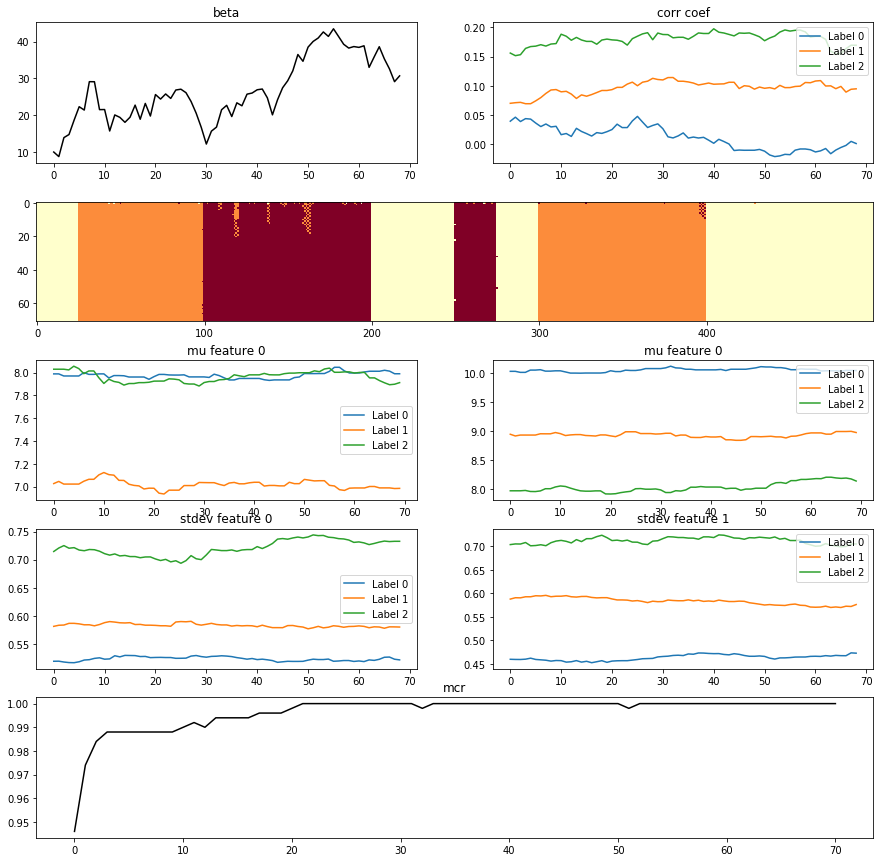

In [16]:
ex1.diagnostics_plot(true_labels=latent_1D)

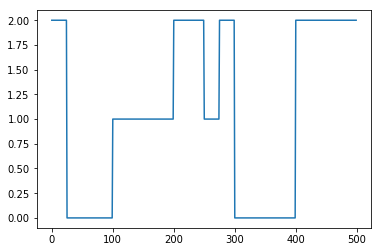

In [18]:
plt.plot(latent_1D)

# COV PROPOSAL TESTS

In [18]:
0.45**(1/2)

0.6708203932499369

In [38]:
cov = np.array([[[  1.99561992e+01 , -1.45150996e+00 , -2.63756395e+00  , 6.96056263e+00,    -1.01622760e+00],
  [ -1.45150996e+00 ,  1.17306877e-01  , 1.34722716e-01 , -6.38203391e-01,     8.36635998e-02],
  [ -2.63756395e+00 ,  1.34722716e-01 ,  6.40140987e+00 ,  1.07719128e+00,     2.09006538e-01],
  [  6.96056263e+00,  -6.38203391e-01 ,  1.07719128e+00 ,  4.75785818e+00,    -5.04168206e-01],
  [ -1.01622760e+00 ,  8.36635998e-02 ,  2.09006538e-01  ,-5.04168206e-01,     1.21996211e-01]]])

In [39]:
np.shape(cov)

(1, 5, 5)

In [ ]:
c1 = scipy.stats.multivariate_normal([6,9,10], np.eye(3)*0.25)
c2 = scipy.stats.multivariate_normal([8,8,11], np.eye(3)*0.15)
c3 = scipy.stats.multivariate_normal([8,11,9], np.eye(3)*0.35)

In [55]:
0.25**(1/2)

0.5

In [32]:
cov = np.array([[[ 1.70240204,  0.13019169,  0.26507972, -0.05779667],
 [ 0.13019169,  1.70098472, -0.06757848,  0.07736503],
 [ 0.26507972, -0.06757848,  1.60775912, -0.22083958],
 [-0.05779667 , 0.07736503, -0.22083958,  1.99746643]]])

In [33]:
np.shape(cov)

(1, 4, 4)

In [33]:
np.linalg.svd(cov[0, :, :])

(array([[-0.34658954,  0.68413653,  0.25486621, -0.58896189],
        [ 0.10536204,  0.58889702, -0.74277933,  0.30062935],
        [-0.48871925,  0.23117566,  0.41103607,  0.73400317],
        [ 0.79368005,  0.36292605,  0.46300262,  0.15487163]]),
 array([ 2.16896074,  1.87338189,  1.64548441,  1.32078527]),
 array([[-0.34658954,  0.10536204, -0.48871925,  0.79368005],
        [ 0.68413653,  0.58889702,  0.23117566,  0.36292605],
        [ 0.25486621, -0.74277933,  0.41103607,  0.46300262],
        [-0.58896189,  0.30062935,  0.73400317,  0.15487163]]))

In [47]:
cov = np.array([[[ 3.,  0.2,  0.3],
       [ 0.2,  2.,  0.6],
       [ 0.3,  0.6,  4.]]])

In [48]:
np.shape(cov)

(1, 3, 3)

In [49]:
covdiff = cov - propose_cov(cov, 3,1, 0.00005, 0.0005)
covdiff

 shp v_l: (3, 3)
 shp d_l: (3,)


array([[[-0.00590155,  0.03395092,  0.03608643],
        [ 0.03395092, -0.00803107, -0.00943427],
        [ 0.03608643, -0.00943427,  0.00324243]]])

In [24]:
from itertools import combinations
from scipy.stats import multivariate_normal

In [50]:
cov = np.array([[[ 1.70240204,  0.13019169,  0.26507972, -0.05779667],
 [ 0.13019169,  1.70098472, -0.06757848,  0.07736503],
 [ 0.26507972, -0.06757848,  1.60775912, -0.22083958],
 [-0.05779667 , 0.07736503, -0.22083958,  1.99746643]]])

covdiff = cov - propose_cov(cov, 4,1, 0.00005, 0.0005)
covdiff

 shp v_l: (4, 4)
 shp d_l: (4,)


array([[[-0.00331711, -0.01200307, -0.00910957, -0.00063114],
        [-0.01200307, -0.00658348, -0.00219675, -0.00707097],
        [-0.00910957, -0.00219675, -0.00494187, -0.01065656],
        [-0.00063114, -0.00707097, -0.01065656,  0.01388612]]])

In [61]:
cov = np.array([[[  1.99561992e+01 , -1.45150996e+00 , -2.63756395e+00  , 6.96056263e+00,    -1.01622760e+00],
  [ -1.45150996e+00 ,  1.17306877e-01  , 1.34722716e-01 , -6.38203391e-01,     8.36635998e-02],
  [ -2.63756395e+00 ,  1.34722716e-01 ,  6.40140987e+00 ,  1.07719128e+00,     2.09006538e-01],
  [  6.96056263e+00,  -6.38203391e-01 ,  1.07719128e+00 ,  4.75785818e+00,    -5.04168206e-01],
  [ -1.01622760e+00 ,  8.36635998e-02 ,  2.09006538e-01  ,-5.04168206e-01,     1.21996211e-01]]])

covdiff = cov - propose_cov(cov, 5,1, 0.000000005, 0.00000005)
covdiff

 shp v_l: (5, 5)
 shp d_l: (5,)


array([[[ -1.32504532e-03,  -3.31717970e-03,   1.94099542e-03,
           3.16929509e-04,   1.27308342e-03],
        [ -3.31717970e-03,   4.97891541e-04,  -3.76669214e-04,
          -1.40158481e-03,   9.95005537e-05],
        [  1.94099542e-03,  -3.76669214e-04,   1.46475731e-03,
          -2.43689538e-04,  -3.20029701e-03],
        [  3.16929509e-04,  -1.40158481e-03,  -2.43689538e-04,
          -2.56884675e-04,  -6.19464331e-04],
        [  1.27308342e-03,   9.95005537e-05,  -3.20029701e-03,
          -6.19464331e-04,  -1.91775455e-04]]])

In [56]:
cov = np.array([[[ 3.,  0.2,  0.3,  0.4,  0.6],
         [ 0.2,  4.,  0.3,  0.5,  0.2],
         [ 0.3,  0.3,  6.,  0.7,  1.],
         [ 0.4,  0.5,  0.7,  2.,  0.4],
         [ 0.6,  0.2,  1.,  0.4,  3.]]])

covdiff = cov - propose_cov(cov, 5,1, 0.00005, 0.0005)
covdiff

 shp v_l: (5, 5)
 shp d_l: (5,)


array([[[ 0.00402245,  0.00542103,  0.07907599,  0.03555844,  0.02765139],
        [ 0.00542103, -0.0607357 , -0.10522585, -0.050517  , -0.02679857],
        [ 0.07907599, -0.10522585, -0.04996802,  0.00120204,  0.08723668],
        [ 0.03555844, -0.050517  ,  0.00120204, -0.0097601 ,  0.04280319],
        [ 0.02765139, -0.02679857,  0.08723668,  0.04280319,  0.09737256]]])

In [41]:
def _cov_proposal_rotation_matrix(x, y, theta):
    """

    :param x, y: two base vectors defining a plane
    :param theta: rotation angle in this plane
    :return: rotation matrix for covariance proposal step
    """
    x = np.array([x]).T
    y = np.array([y]).T

    uu = x / np.linalg.norm(x)
    vv = y - uu.T @ y * uu
    vv = vv / np.linalg.norm(vv)
    # what is happening

    # rotation_matrix = np.eye(len(x)) - np.matmul(uu, uu.T) - np.matmul(np.matmul(vv, vv.T) + np.matmul(np.hstack((uu, vv)), np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])), np.hstack((uu, vv)).T)
    rotation_matrix = np.eye(len(x)) - uu @ uu.T - vv @ vv.T + np.hstack((uu, vv)) @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) @ np.hstack((uu, vv)).T
    return rotation_matrix

In [23]:
def propose_cov(cov_prev, n_feat, n_labels, cov_jump_length, theta_jump_length):
    """

    :param cov_prev:
    :param cov_jump_length:
    :param theta_jump_length:
    :return:
    """
    # do svd on the previous covariance matrix
    comb = list(combinations(range(n_feat), 2))
    n_comb = len(comb)
    theta_jump = multivariate_normal(mean=[0 for i in range(n_comb)], cov=np.ones(n_comb) * theta_jump_length).rvs()
    cov_prop = np.zeros_like(cov_prev)

    # print("cov_prev:", cov_prev)

    for l in range(n_labels):

        v_l, d_l, v_l_t = np.linalg.svd(cov_prev[l, :, :])
        print(" shp v_l:", np.shape(v_l))
        print(" shp d_l:", np.shape(d_l))
        # generate d jump
        log_d_jump = multivariate_normal(mean=[0 for i in range(n_feat)], cov=np.eye(n_feat) * cov_jump_length).rvs()
        # sum towards d proposal
        # if l == 0:
        d_prop = np.diag(np.exp(np.log(d_l) + log_d_jump))
        # else:
        #    d_prop = np.vstack((d_prop, np.exp(np.log(d_l) + np.log(d_jump))))

        # now tackle generating v jump
        a = np.eye(n_feat)
        # print("a init:", a)
        # print("shape a:", np.shape(a))
        for j in range(n_comb):
            rotation_matrix = _cov_proposal_rotation_matrix(v_l[:, comb[j][0]], v_l[:, comb[j][1]], theta_jump[j])
            # print("rot mat:", rotation_matrix)
            # print("rot mat:", rotation_matrix)
            a = rotation_matrix @ a
            # print("a:", a)
        # print("v_l:", np.shape(v_l))
        v_prop = a @ v_l  # np.matmul(a, v_l)
        # print("d_prop:", d_prop)
        # print("v_prop:", np.shape(v_prop))
        # TODO: Is this proposal covariance slicing correct?
        cov_prop[l, :, :] = v_prop @ d_prop @ v_prop.T  # np.matmul(np.matmul(v_prop, d_prop), v_prop.T)
        # print("cov_prop:", cov_prop)

    return cov_prop

In [80]:
import sys
for i in range(200):
    sys.stdout.write(str(i))
    sys.stdout.write('\r')
    sys.stdout.flush()